In [35]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Handle table-like data and matrices
import numpy as np
import pandas as pd
from pandas import DataFrame, Series


from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor
from sklearn.svm import SVR

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Others
from datetime import datetime


from __future__ import print_function
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot

# Configure visualisations
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 8, 6

In [36]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_pred = y_pred[y_true != 0]
    y_true = y_true[y_true != 0]
    return np.mean(np.abs((y_true - y_pred) / y_true))

In [3]:
full_df = pd.read_pickle('../datasets/new_full_task2.pkl')

In [15]:
full_df['Time'] = list(map(lambda x: str(x)[:-3], full_df.index.time))

In [149]:
lags = ['AR.L1', 'AR.L2', 'AR.L3', 'S72.L1', 'S72.L2', 'S72.L3']

for column in full_df[full_df.columns[:5]]:
    series = full_df[column]
    lag_data = list([series.shift(s) for s in [1, 2, 3, 15, 16, 17]])
    column_lags = [column + '.' + lag for lag in lags]
    df = pd.DataFrame(dict(zip(column_lags, lag_data)))
    full_df = full_df.join(df)

In [151]:
full_df.columns

Index(['T1D0', 'T1D1', 'T2D0', 'T3D0', 'T3D1', 'HeavyRain', 'LightRain',
       'Rain', 'Sunny', 'DayOfWeek', 'BeforeNationalDay',
       'NationalDayFront(1-4)', 'NationalDayTail(5-7)', 'Weekend',
       'WorkingDay', 'WorkingWeekend', 'Time', 'T1D0.AR.L1', 'T1D0.AR.L2',
       'T1D0.AR.L3', 'T1D0.S72.L1', 'T1D0.S72.L2', 'T1D0.S72.L3', 'T1D1.AR.L1',
       'T1D1.AR.L2', 'T1D1.AR.L3', 'T1D1.S72.L1', 'T1D1.S72.L2', 'T1D1.S72.L3',
       'T2D0.AR.L1', 'T2D0.AR.L2', 'T2D0.AR.L3', 'T2D0.S72.L1', 'T2D0.S72.L2',
       'T2D0.S72.L3', 'T3D0.AR.L1', 'T3D0.AR.L2', 'T3D0.AR.L3', 'T3D0.S72.L1',
       'T3D0.S72.L2', 'T3D0.S72.L3', 'T3D1.AR.L1', 'T3D1.AR.L2', 'T3D1.AR.L3',
       'T3D1.S72.L1', 'T3D1.S72.L2', 'T3D1.S72.L3'],
      dtype='object')

In [29]:
time_dummies = pd.get_dummies(full_df['Time'], prefix='Time')
dayofweek_dummies = pd.get_dummies(full_df['DayOfWeek'], prefix='DayOfWeek')

In [301]:
full_df_train = full_df[:'2016-10-17'][['T1D0',  'HeavyRain', 'LightRain',
                                        'Rain', 'Sunny',  'BeforeNationalDay',
                                        'NationalDayFront(1-4)', 'NationalDayTail(5-7)', 'Weekend',
                                        'WorkingDay', 'WorkingWeekend', ]]

In [302]:
full_df_train = full_df_train.join(time_dummies).join(dayofweek_dummies)

In [303]:
full_df_train.columns

Index(['T1D0', 'HeavyRain', 'LightRain', 'Rain', 'Sunny', 'BeforeNationalDay',
       'NationalDayFront(1-4)', 'NationalDayTail(5-7)', 'Weekend',
       'WorkingDay', 'WorkingWeekend', 'Time_00:00', 'Time_00:20',
       'Time_00:40', 'Time_01:00', 'Time_01:20', 'Time_01:40', 'Time_02:00',
       'Time_02:20', 'Time_02:40', 'Time_03:00', 'Time_03:20', 'Time_03:40',
       'Time_04:00', 'Time_04:20', 'Time_04:40', 'Time_05:00', 'Time_05:20',
       'Time_05:40', 'Time_06:00', 'Time_06:20', 'Time_06:40', 'Time_07:00',
       'Time_07:20', 'Time_07:40', 'Time_08:00', 'Time_08:20', 'Time_08:40',
       'Time_09:00', 'Time_09:20', 'Time_09:40', 'Time_10:00', 'Time_10:20',
       'Time_10:40', 'Time_11:00', 'Time_11:20', 'Time_11:40', 'Time_12:00',
       'Time_12:20', 'Time_12:40', 'Time_13:00', 'Time_13:20', 'Time_13:40',
       'Time_14:00', 'Time_14:20', 'Time_14:40', 'Time_15:00', 'Time_15:20',
       'Time_15:40', 'Time_16:00', 'Time_16:20', 'Time_16:40', 'Time_17:00',
       'Time_17:2

In [304]:
full_df_train['T1D0'] = np.log(full_df_train['T1D0'] + 1)

In [312]:
columns = full_df_train.columns.values

In [313]:
mean_dict = full_df_train.T1D0.groupby(full_df_train.index.time).mean().to_dict()

In [314]:
full_df_train['Mean'] = full_df_train.index.map(lambda dt:mean_dict[dt.time()])

In [361]:
train, test = full_df_train[:'2016-10-12'].fillna(
    0), full_df_train['2016-10-13':].fillna(0)

X_train = train[columns[1:]]
y_train = train[columns[0]]

X_test = test[columns[1:]].between_time('8:00', '10:00')
y_test = test[columns[0]].between_time('8:00', '10:00')

model = Lasso(alpha=0.00001)
model.fit(X_train, y_train)
y_train_predict = model.predict(X_train)
y_test_predict = model.predict(X_test)


train_mape = mean_absolute_percentage_error(
    np.exp(y_train) - 1,
    np.exp(y_train_predict) - 1
)

test_mape = mean_absolute_percentage_error(
    np.exp(y_test) - 1,
    np.exp(y_test_predict) - 1
)

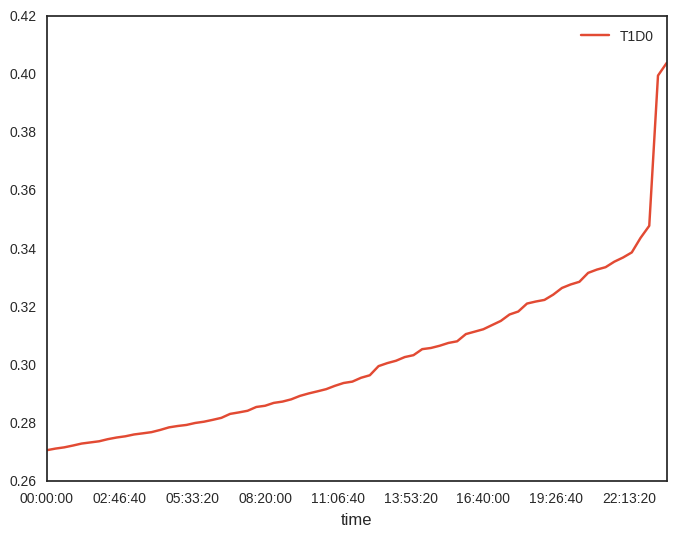

In [362]:
abs(y_train_predict -
    y_train).to_frame().sort_values(by=['T1D0']).groupby(y_train.index.time).mean().plot()

In [363]:
print(train_mape)
print(test_mape)

0.3518344037873054
0.18125645882328378


In [364]:
coef = pd.Series(model.coef_, X_train.columns)
coef.to_frame().sort_values(by=[0])

,0
Time_01:40,-0.480946
Time_02:00,-0.476635
Time_01:20,-0.474093
WorkingWeekend,-0.462890
Time_01:00,-0.451381
Time_02:20,-0.450323
Time_02:40,-0.442993
Time_03:20,-0.414555
Time_03:40,-0.406739
Time_03:00,-0.406605
